## This note book gives the trend of multiple words in multiple mailing lists

What it does:
-it computes and plot word counts over time, on aggregated mailing lists' data.
-it exports emails that contains selected words 

Parameters to set options:
-it can track one or more words, according to the number of words set in the variable 'checkwords' 
-it can look in one or more mailing lists, according to how many urls are set; word counts are aggregated across mls
-it can look at literal words or at stemmed words, according to the 'stem' parameter

Useful extensions:
-export dictionary with wordcount trends on individual mailing lists
-look at compund words (e.g. 'human rights')
-give option to SUM word counts instead of treating words separately
-give possibility to normalize word counts

In [1]:
%matplotlib inline

/home/sb/anaconda/envs/nllz/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from bigbang.archive import Archive
import bigbang.parse as parse
import bigbang.graph as graph
import bigbang.mailman as mailman
import bigbang.process as process
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint as pp
import pytz
import numpy as np
import math
import nltk
from itertools import repeat
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()
from nltk.corpus import stopwords
import re
import csv

In [3]:
#insert a list of the urls of downloaded mailing lists that you want to include in the analysis. 
#data will be merged: multiple mailing lists are treated as a unique corpus
#e.g. urls  = ["https://mm.icann.org/pipermail/cc-humanrights/", 
#              "https://mm.icann.org/pipermail/euro-board/"]

from bigbang.archive import load as load_archive

paths = ["../archives/http:/mm.icann.org/pipermail/cc-humanrights.csv", 
        "../archives/http:/mm.icann.org/pipermail/alac.csv"]


#archives= [Archive(url,archive_dir="../archives") for url in urls]

archives = [load_archive(path) for path in paths]

/home/sb/projects/nllz-bigbang/bigbang/bigbang/archive.py:73: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  self.data.sort(columns='Date', inplace=True)


In [4]:
#insert a list of *single* words to be tracked e.g. checkwords = ['rights', 'economy', 'human']
checkwords = ["internet","right","human"]



#to stem or not to stem? 
#if stem is set to True, then checkwords should be stemmed words (no plurals, no suffixes, etc.)
#if stem is set to False, then checkwords are searched for their literal spelling
stem = False


#extension: filter by date?

In [5]:
df = archives[0].data.copy()

def count_words(text,checkwords):
    w = text.replace("'", "")
    k = re.sub(r'[^\w]', ' ', w)
    k = k.lower()
    
    t = nltk.tokenize.word_tokenize(k)

    words_count = {}
    
    for checkword in checkwords:

        words_count[checkword] = 0
        for g in t:
            if stem: 
                try:
                    word = st.stem(g)
                except:
                    print "Error while stemming the word "+g
                    pass
            else:
                word = g
        
            if word == checkword:
                words_count[checkword] += 1


    return words_count

df['WordCount'] = df['Body'].apply(lambda x: count_words(x,checkwords))

#df['WordCount']

In [6]:
#save each email in a file based on which checkword it contains. good for doing some qualitative analysis

#set the path where the data are to be saved
path = '../'


for word in checkwords:
    print "Saving data for checkword "+word+"..."
    file_f = open(path+word+'.csv', "wb")
    file_w = csv.writer(file_f)
    for row in df.iterrows():
        if row[1]["WordCount"][word] != 0:
            file_w.writerow(row[1])
    file_f.close()

Saving data for checkword internet...
Saving data for checkword right...
Saving data for checkword human...


In [7]:
#create list of month based on time distribution of emails
start_date = df.iloc[0]["Date"]
end_date = df.iloc[len(df.index)-1]["Date"]
total_month = (end_date.year - start_date.year)*12 + (end_date.month-start_date.month+1)
k_month = []
temp_year = start_date.year
temp_month = start_date.month
for i in range(total_month):
    k_month.append((temp_year, temp_month))
    if temp_month == 12:
        temp_year += 1
        temp_month = 0
    temp_month += 1

In [8]:
#create dictionary of words and occurrences by month
word_time_dict = {}
for word in checkwords:
    word_time_dict[word] = {}
for row in df.iterrows():
    for word in checkwords:
        if (row[1]['Date'].year, row[1]['Date'].month) not in word_time_dict[word]:
            word_time_dict[word][(row[1]['Date'].year, row[1]['Date'].month)] = row[1]["WordCount"][word]
        else:
            word_time_dict[word][(row[1]['Date'].year, row[1]['Date'].month)] += row[1]["WordCount"][word]
word_by_month = {}
for word in checkwords:
    word_by_month[word] = []
for item in k_month:
    for word in checkwords:
        if item in word_time_dict[word]:
            word_by_month[word].append(word_time_dict[word][item])
        else:
            word_by_month[word].append(0)



In [9]:
x = range(1,total_month+1)
str_to_eval = ""
for word in checkwords:
    str_to_eval += "["+",".join(str(y) for y in word_by_month[word])+"], x, "
str_to_eval = str_to_eval[:-5]

str_to_eval

'[15,14,3,52,63,78,76,1,50,93,10,9,21,29,39,22,20,38,22], x, [89,3,4,11,23,7,12,1,10,5,2,0,6,4,24,4,4,43,187], x, [229,277,92,182,672,162,243,14,452,239,70,140,125,192,541,232,360,373,75]'

/home/sb/anaconda/envs/nllz/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


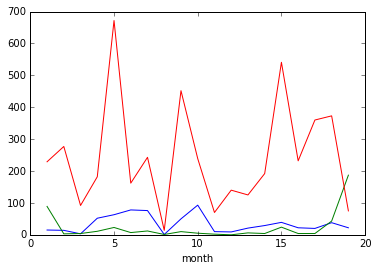

In [10]:
#plot the word trend(s) against months
x = range(1,total_month+1)
str_to_eval = ""
for word in checkwords:
    str_to_eval += "["+",".join(str(y) for y in word_by_month[word])+"], x, "
str_to_eval = str_to_eval[:-5]
eval("plt.plot(x,"+str_to_eval+")")
plt.xlabel("month")
plt.legend()